In [125]:
import pandas as pd

data_dir = 'C:/ZhangLI/Codes/DataSet/个人违贷/official_data/'
data_dir = 'E:/Dataset/个人违贷/official_data/'
train_pub = pd.read_csv(data_dir+'train_public.csv')
train_net = pd.read_csv(data_dir+'train_internet.csv')
test_pub = pd.read_csv(data_dir+'test_public.csv')

In [128]:
# 查看数据维度
def describe_data(train, test):
    print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
    print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')
    # 查看哪些列具有缺失值
    print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')
    print(f'The train missing column: {train.columns[train.isna().any()].tolist()}.')
    print(f'There are {test.isnull().any().sum()} columns in test dataset with missing values.')
    print(f'The test missing column: {test.columns[test.isna().any()].tolist()}.')
    # 查看数据值唯一的列
    one_value_cols = []
    one_value_cols += [col for col in train.columns if train[col].nunique() <= 1]
    one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
    print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
    print(f'{one_value_cols} of unique values in the train set')
    print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')
    print(f'{one_value_cols_test} of unique values in the test set')
    # 查看数据缺失值情况
    nan_clos = [col for col in train.columns if train[col].isna().sum() / train.shape[0] > 0.90]
    print(f'There are {len(nan_clos)} columns in train dataset with [na value > 0.9].')
    nan_clos_test = [col for col in test.columns if test[col].isna().sum() / test.shape[0] > 0.90]
    print(f'There are {len(nan_clos_test)} columns in test dataset with [na value > 0.9].')
    
    return one_value_cols + nan_clos
    
describe_data(train_pub, test_pub)
# describe_data(train_net, train_net)


# 查看数据类型
# print('The train dtype:')
# origin_train.dtypes
# # 查看缺失值并排序
train_net.isna().sum().sort_values(ascending=False)
# # 删除缺失值大于95%
# origin_train.columns[(origin_train.isna().sum() / origin_train.shape[0])>0.89]
# 查看特征类型 and 判断类别型
# train_net.nunique().sort_values()
print('')

Train dataset has 10000 rows and 39 columns.
Test dataset has 5000 rows and 40 columns.
There are 7 columns in train dataset with missing values.
The train missing column: ['work_year', 'pub_dero_bankrup', 'f0', 'f1', 'f2', 'f3', 'f4'].
There are 6 columns in test dataset with missing values.
The test missing column: ['pub_dero_bankrup', 'f0', 'f1', 'f2', 'f3', 'f4'].
There are 1 columns in train dataset with one unique value.
['policy_code'] of unique values in the train set
There are 2 columns in test dataset with one unique value.
['policy_code', 'issue_date_d'] of unique values in the test set
There are 0 columns in train dataset with [na value > 0.9].
There are 0 columns in test dataset with [na value > 0.9].



1. 处理完特征后，不连接 internet的数据，使用1w进行训练


In [84]:
train_pub['policy_code'].value_counts()
# 1. common_feature  数据分布是否相似
# 2. 特征处理
# 3. 训练集 和 测试集 的数据分布这个很重要的
# 4. 每个特征的类型，minmax scalar
# 5. pub 和 net 的 不同特征数据分布
# -------pub[known_dero, known_outstanding_loan, app_type]   
train_net['isDefault'] = train_net['is_default']
common_feature = list(set(train_pub.columns).intersection(set(train_net.columns)))
train_pub_new = train_pub[common_feature]
train_net_new = train_net[common_feature]
def get_feature_type(dataframe):
    col_type = {}
    for type_c in set(dataframe.dtypes.tolist()):
        col_type[str(type_c)] = []
    for col in dataframe.columns:
        col_type[str(dataframe[col].dtypes)] += [col]
    return col_type

In [122]:
# plot the feature kde
import matplotlib.pyplot as plt
import seaborn as sns
def plot_feature_kde(train_data, test_data, features=[]):
    """连续变量"""
    plt.clf()
    fcols = 4
    frows = len(features)
    plt.figure(figsize=(6*fcols, frows*1.5))
    i = 0
    for col in features:
        i += 1
        plt.subplot(frows//fcols+1, fcols, i)
        sns.kdeplot(train_data[col], color="Blue", shade=True, label='Train')
        sns.kdeplot(test_data[col], color="Red", shade=True, label='Test')
    plt.show()
feature_type = get_feature_type(train_pub)
# cols = feature_type.keys()
# recircle_u  train/test 
# drop ['user_id', 'loan_id'] earnly_return ?  'scoring_low', 'scoring_high', 'f1', 'early_return_amount_3mon' 这个应该怎么分析
# object ?
feature_type['int64'].remove('known_outstanding_loan')
feature_type['int64'].remove('known_dero')
feature_type['int64'].remove('app_type')
# plot_feature_kde(train_pub, test_pub, ['recircle_u', 'known_dero'])
train_net.scoring_low.value_counts(ascending=True)
# test_pub.known_dero.value_counts(ascending=True)
train_pub[['class','employer_type','industry','work_year','issue_date','earlies_credit_mon']]
train_pub['employer_type'].unique()
train_net['pub_dero_bankrup'].isna().sum()
# train_pub['work_year'].isna().sum()

375

In [ ]:
# 1. work_year 的数据填充不能这么随意
# ---------------------------------- pub_dero_bankrup 填充众数
# 2. 其他缺失值的填充
# 3. 不将 pub 和 net 连接起来，查看效果
# ---------------------------------- 85%
# 4. 连接起来的话，需要对数据进行更加细致的分析
# 5. 衍生其他的特征

In [151]:
employer_type = train_pub['employer_type'].value_counts().index
dict(zip(employer_type, [0,1,2,3,4,5]))
industry = train_pub['industry'].value_counts().index
print(industry)
dict(zip(industry, [i for i in range(15)]))
train_pub['earlies_credit_mon']

Index(['金融业', '电力、热力生产供应业', '公共服务、社会组织', '住宿和餐饮业', '信息传输、软件和信息技术服务业', '文化和体育业',
       '建筑业', '房地产业', '采矿业', '交通运输、仓储和邮政业', '农、林、牧、渔业', '制造业', '批发和零售业',
       '国际组织'],
      dtype='object')


0        1-Dec
1       Apr-90
2       Oct-91
3        1-Jun
4        2-May
         ...  
9995     6-Feb
9996    May-97
9997    Feb-87
9998    Oct-92
9999     9-Feb
Name: earlies_credit_mon, Length: 10000, dtype: object

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 500 rounds
[100]	valid_0's auc: 0.881554
[200]	valid_0's auc: 0.886766
[300]	valid_0's auc: 0.885686
[400]	valid_0's auc: 0.885665
[500]	valid_0's auc: 0.884931
[600]	valid_0's auc: 0.884942
Early stopping, best iteration is:
[168]	valid_0's auc: 0.887036


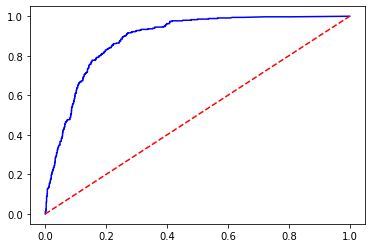

KeyError: 'issue_date'

In [153]:
import datetime
def preprocessor(dataframe):
    dataframe['issue_date'] = pd.to_datetime(dataframe['issue_date'])
    dataframe['issue_date_y'] = dataframe['issue_date'].dt.year
    dataframe['issue_date_m'] = dataframe['issue_date'].dt.month
#     dataframe['issue_date_d'] = dataframe['issue_date'].dt.day  # unique value 
    
    # dataframe['earlies_credit_y'] = dataframe['earlies_credit_mon'].split('-')[1]
    dataframe.drop('earlies_credit_mon', axis = 1, inplace = True)
    # dataframe['earlies_credit_y'] = dataframe['earlies_credit_mon'].split('-')[0].map()
    # set origin date
    # get the diff bewteen now and origin-date
    origin_date = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    dataframe['issue_date_diff'] = dataframe['issue_date'].apply(lambda x: x-origin_date).dt.days
    dataframe.drop('issue_date', axis = 1, inplace = True)
    # 就业类型
    employer_type = dataframe['employer_type'].value_counts().index
    industry = dataframe['industry'].value_counts().index
    # dict()
    emp_type_dict = dict(zip(employer_type, [0,1,2,3,4,5]))
    industry_dict = dict(zip(industry, [i for i in range(15)]))
    # 
    dataframe['work_year'].fillna('10+ years', inplace=True)

    work_year_map = {'10+ years': 10, '2 years': 2, '< 1 year': 0, '3 years': 3, '1 year': 1,
         '5 years': 5, '4 years': 4, '6 years': 6, '8 years': 8, '7 years': 7, '9 years': 9}
    dataframe['work_year']  = dataframe['work_year'].map(work_year_map)

    dataframe['class'] = dataframe['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

    emp_type_dict = {'政府机构': 1, '幼教与中小学校': 2, '高等教育机构': 3, '世界五百强': 4, '上市企业': 5, '普通企业': 6}
    dataframe['employer_type'] = dataframe['employer_type'].map(emp_type_dict)

    dataframe['industry'] = dataframe['industry'].map(industry_dict)
    return dataframe

# 数据处理
train_net['isDefault'] = train_net['is_default']
common_feature = list(set(train_pub.columns).intersection(set(train_net.columns)))
import copy
train_pub_new = copy.deepcopy(train_pub)
# train_df = pd.concat([train_pub_new, train_net_new])
# 特征处理
train_df_new = preprocessor(train_pub_new)
# 模型训练
X_train = train_df_new.drop('isDefault', axis=1)
y_train = train_df_new['isDefault']
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2)

import lightgbm as lgb
train_matrix = lgb.Dataset(train_x, label=train_y)
valid_matrix = lgb.Dataset(val_x, label=val_y)
params = {
    'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.01,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 50,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=2000, verbose_eval=100, early_stopping_rounds=500)

from sklearn import metrics
from sklearn.metrics import roc_auc_score

val_pred_lgb = model.predict(val_x, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(val_y, val_pred_lgb)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0,1], 'r--')
plt.show()
# 模型预测
common_feature.remove('isDefault')
test_pub_new = test_pub
test_df_new = preprocessor(test_pub_new)
predict = model.predict(test_df_new, num_iteration=model.best_iteration)
# 生成结果
submission = pd.DataFrame({'id':test_pub_new['loan_id'], 'isDefault':predict})
submission.to_csv('submission.csv', index = None)

In [127]:
pd.read_csv('submission.csv')

,id,isDefault
0,1000575,0.029621
1,1028125,0.087225
2,1010694,0.029253
3,1026712,0.029044
4,1002895,0.034675
...,...,...
4995,1008856,0.392261
4996,1016651,0.029621
4997,1024140,0.033795
4998,1014316,0.029621
